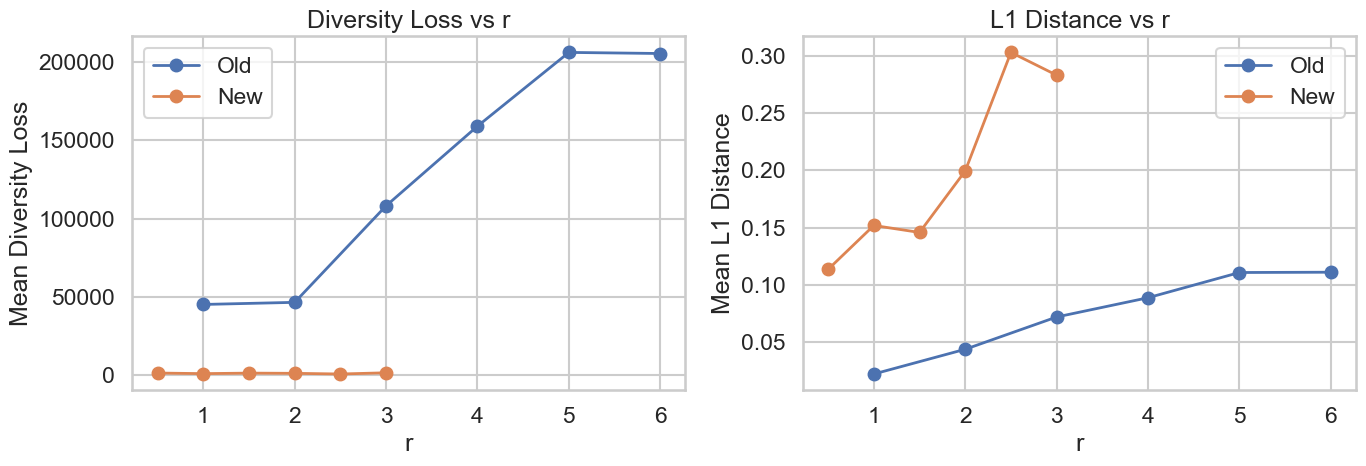

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df_new = pd.read_csv("gen_dataset_new/region_constr_with_inputvar/dataset_info.csv")
df_old = pd.read_csv("gen_dataset_new/old_constr_unsup/dataset_info.csv")

# Convert string "[x]" → float x
for df in [df_new, df_old]:
    df["L1_distance"] = df["L1_distance"].apply(lambda x: float(x[1:-1]))
    df["diversity_loss"] = df["diversity_loss"].apply(lambda x: float(x[1:-1]))

# Aggregate
old_grp = df_old.groupby("r").mean(numeric_only=True)
new_grp = df_new.groupby("r").mean(numeric_only=True)

# Style
sns.set(style="whitegrid", context="talk")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# ---- Diversity Loss ----
axes[0].plot(old_grp.index, old_grp["diversity_loss"],
             marker="o", label="Old", linewidth=2)
axes[0].plot(new_grp.index, new_grp["diversity_loss"],
             marker="o", label="New", linewidth=2)

axes[0].set_title("Diversity Loss vs r")
axes[0].set_xlabel("r")
axes[0].set_ylabel("Mean Diversity Loss")
axes[0].legend()

# ---- L1 Distance ----
axes[1].plot(old_grp.index, old_grp["L1_distance"],
             marker="o", label="Old", linewidth=2)
axes[1].plot(new_grp.index, new_grp["L1_distance"],
             marker="o", label="New", linewidth=2)

axes[1].set_title("L1 Distance vs r")
axes[1].set_xlabel("r")
axes[1].set_ylabel("Mean L1 Distance")
axes[1].legend()

plt.tight_layout()
plt.show()


<Axes: xlabel='r'>

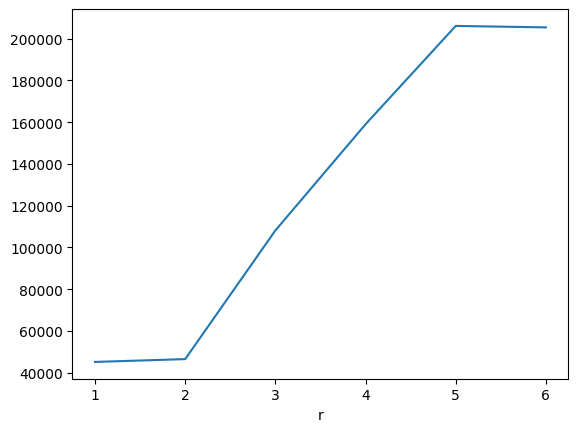

<Axes: xlabel='r'>

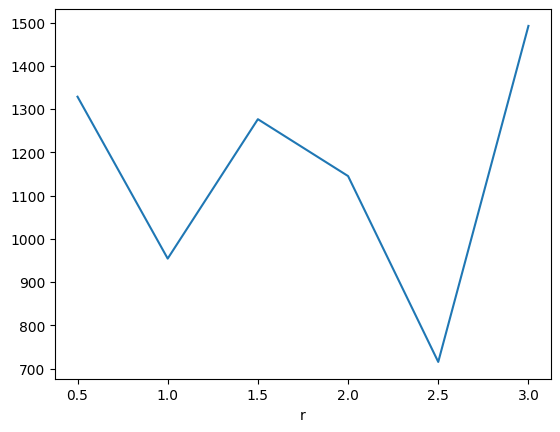

In [38]:
df_new.groupby("r").diversity_loss.mean().plot()

In [23]:
import pandas as pd

df = pd.read_csv("model_results_new/region_constr_with_inputvar_unsup.csv")
df[["c", "r", "b", "m", "data_seed"]] = df["experiment_path"].str.split("_", expand=True)
df["r"] = df["r"].astype(float)
df["data_seed"] = df["data_seed"].astype(float)
df["r"] = pd.to_numeric(df["r"], errors="coerce")

In [24]:
df.columns

Index(['results_per_region_model1', 'model1_mae', 'model2_mae', 'test',
       'model_1_violation_loss', 'model_2_violation_loss', 'experiment_path',
       'seed', 'constraints_weight', 'model1batch_size', 'model1epochs',
       'model1lr', 'model1hidden_dim', 'model1device', 'model1patience',
       'model1constraints_weight', 'model2batch_size', 'model2epochs',
       'model2lr', 'model2hidden_dim', 'model2device', 'model2patience', 'c',
       'r', 'b', 'm', 'data_seed'],
      dtype='object')

In [25]:
df_05 = (
    df[df["constraints_weight"] == 0.5]
    .set_index(["r", "data_seed"])
)

df_0 = (
    df[df["constraints_weight"] == 0]
    .set_index(["r", "data_seed"])
)

diff = df_05.model1_mae - df_0.model1_mae


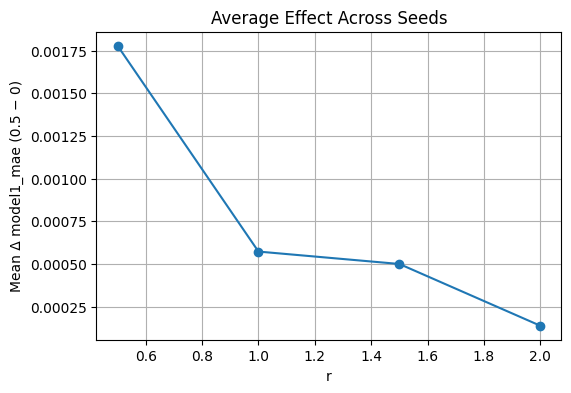

In [27]:
diff_mean = diff.groupby(level="r").mean()
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(diff_mean.index, diff_mean.values, marker="o")
plt.xlabel("r")
plt.ylabel("Mean Δ model1_mae (0.5 − 0)")
plt.title("Average Effect Across Seeds")
plt.grid(True)
plt.show()


In [13]:
import pandas as pd

df = pd.read_csv("model_results_new/test.csv")

split_cols = df["experiment_path"].str.split("_", expand=True)
df["r"] = pd.to_numeric(split_cols[1], errors="coerce")

In [14]:
mae_pivot

,constraints_weight,0.0,0.5,mae_diff
c,seed,,,
5,1,0.204776,0.195306,-0.00947


In [21]:
mae_pivot

,constraints_weight,0.0,0.5,mae_diff
r,seed,,,
1.0,1,0.195206,0.279399,0.084193
2.0,1,0.202888,0.230131,0.027242
3.0,1,0.198864,0.181643,-0.017221
4.0,1,0.219498,0.168339,-0.051159
5.0,1,0.207422,0.117016,-0.090406


constraints_weight    r  seed  mae_diff  violation_diff
0                   1.0     1  0.084193       -0.157414
1                   2.0     1  0.027242       -0.141500
2                   3.0     1 -0.017221       -0.259971
3                   4.0     1 -0.051159       -0.516577
4                   5.0     1 -0.090406       -0.523922


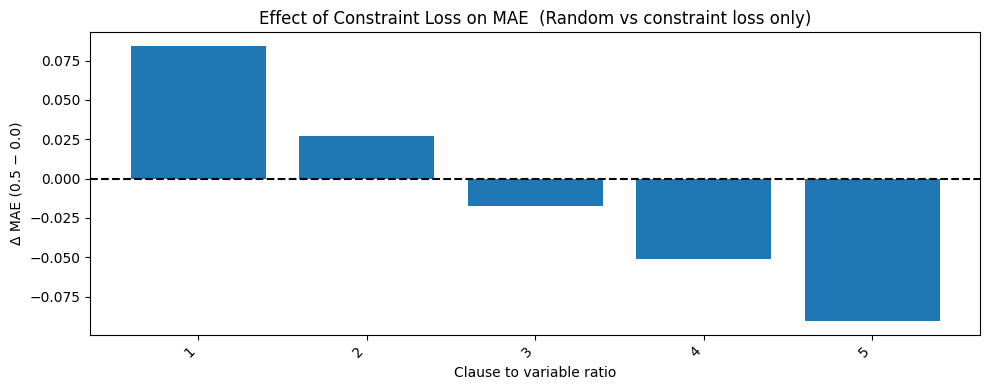

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Assume df already exists
#    (e.g. loaded from CSV or created earlier)
# ------------------------------------------------------------------

# Sanity check: ensure required columns exist
required_cols = [
    "r",
    "seed",
    "constraints_weight",
    "model1_mae",
    "model_1_violation_loss"
]

missing = set(required_cols) - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

# ------------------------------------------------------------------
# 2. Pivot table to align same runs
#    Same run = experiment_path + seed
# ------------------------------------------------------------------

mae_pivot = df.pivot_table(
    index=["r", "seed"],
    columns="constraints_weight",
    values="model1_mae"
)

violation_pivot = df.pivot_table(
    index=["r", "seed"],
    columns="constraints_weight",
    values="model_1_violation_loss"
)

# ------------------------------------------------------------------
# 3. Compute differences
#    (constraints_weight = 0.5 minus 0.0)
# ------------------------------------------------------------------

mae_pivot["mae_diff"] = mae_pivot[0.5] - mae_pivot[0.0]
violation_pivot["violation_diff"] = violation_pivot[0.5] - violation_pivot[0.0]

# Merge results into one dataframe
results = (
    mae_pivot[["mae_diff"]]
    .join(violation_pivot[["violation_diff"]])
    .reset_index()
)

print(results)

# ------------------------------------------------------------------
# 4. Plot MAE differences
# ------------------------------------------------------------------

plt.figure(figsize=(10, 4))
plt.bar(results["r"], results["mae_diff"])
plt.axhline(0, color="black", linestyle="--")

plt.xlabel("Clause to variable ratio")
plt.ylabel("Δ MAE (0.5 − 0.0)")
plt.title("Effect of Constraint Loss on MAE  (Random vs constraint loss only)")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [1]:
from z3 import *

# path to your SMT2 file
smt_file = "gen_dataset_new/new_constr_input/5_2.0_1_0.1_1/n8_i1_0.smt2"

# Parse the file
solver = Solver()
solver.from_file(smt_file)
print(solver)


[And(Or(x1 >= 1625380726487019/2000000000000000,
        x3 >= i3,
        x5 < 7348662004213181/10000000000000000),
     Or(x3 < 78330740198271/200000000000000,
        x4 >= 305669369294833/625000000000000,
        x6 < i4),
     Or(x4 >= 3680260371060739/5000000000000000,
        x6 >= 22542423732466063/50000000000000000,
        x7 >= i2),
     Or(x3 >= i1,
        x6 < i1,
        x8 >= 1269183043945897/2000000000000000),
     Or(x4 >= 8431104730299399/10000000000000000,
        x5 < i4,
        x8 < i2),
     Or(x2 >= i4,
        x4 >= i3,
        x7 < 12345146680195987/50000000000000000),
     Or(x5 >= 3885043164142963/12500000000000000,
        x6 >= 8038201780963157/10000000000000000,
        x8 >= i1),
     Or(x2 >= 9432890709584587/10000000000000000,
        x5 < i1,
        x6 < i4),
     Or(x1 < i2,
        x2 >= 1157645091058407/2000000000000000,
        x5 >= i4),
     Or(x1 >= i1,
        x3 < 1438715179527757/2000000000000000,
        x7 < 6482691694476207/100000000000

In [3]:
from utils_generator import generate_cnf, cnf_to_smt_over_reals_new

file_path = generate_cnf(n_vars = 8, n_clauses = 8 * 7, index = 1, seed = 1, exp_path = "gen_dataset_new/test")

file_path = cnf_to_smt_over_reals_new(file_path, f"n8_i1_1", exp_path = "gen_dataset_new/test", n_inputs = 4)



SAT on attempt 1


In [2]:
from pysat.formula import CNF
from pysat.solvers import Solver

cnf = CNF(from_file="dataset_input_constr/input_constr/1_3.0_1_0.3_1/n8_i1_0.cnf")

solutions = []

with Solver(bootstrap_with=cnf) as solver:
    while solver.solve():
        model = solver.get_model()
        solutions.append(model)

        # BLOCK the current model
        blocking_clause = [-lit for lit in model]
        solver.add_clause(blocking_clause)

print(f"Number of solutions: {len(solutions)}")

for i, sol in enumerate(solutions):
    print(f"Solution {i+1}: {sol}")


Number of solutions: 11
Solution 1: [-1, -2, 3, -4, -5, -6, -7, -8]
Solution 2: [-1, 2, 3, -4, -5, 6, -7, -8]
Solution 3: [-1, 2, 3, -4, -5, 6, 7, -8]
Solution 4: [-1, 2, 3, -4, -5, 6, 7, 8]
Solution 5: [-1, 2, 3, -4, -5, 6, -7, 8]
Solution 6: [-1, 2, -3, -4, -5, 6, -7, -8]
Solution 7: [-1, -2, -3, -4, -5, 6, -7, -8]
Solution 8: [-1, -2, 3, -4, 5, -6, 7, -8]
Solution 9: [-1, -2, 3, -4, -5, -6, 7, -8]
Solution 10: [1, -2, 3, -4, 5, -6, -7, -8]
Solution 11: [1, -2, 3, 4, 5, -6, -7, -8]


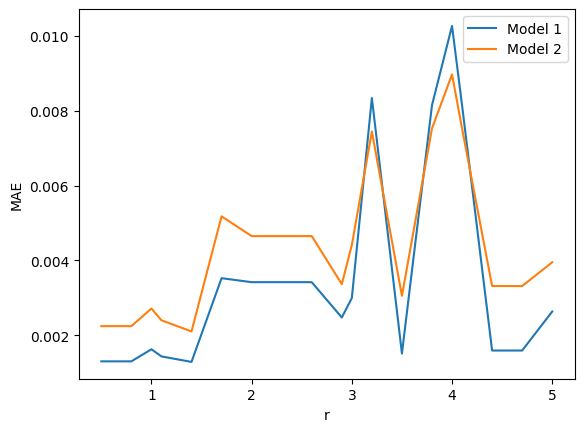

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("dataset_input_constr/resuls_out.csv")
df[["c", "r", "b", "m", "data_seed"]] = df["experiment_path"].str.split("_", expand=True)
df["r"] = df["r"].astype(float).round(2)
# Group by r and take mean
mean_df = (
    df.groupby("r")[["model1_mae", "model2_mae"]]
      .mean()
      .reset_index()
)

# Plot
plt.plot(mean_df["r"], mean_df["model1_mae"], label="Model 1")
plt.plot(mean_df["r"], mean_df["model2_mae"], label="Model 2")
plt.title("")
plt.xlabel("r")
plt.ylabel("MAE")
plt.legend()
plt.show()
